# <center> Introduction to Machine learning 
## <center> BIO_322
## <center> Laurine Song and Matteo Simonet

### Project description: 

The police often need to ascertain whether confiscated substances contain illegal drugs, such as
cocaine or heroin. It is also crucial to determine the purity of samples, i.e. the quantity of pure
cocaine or heroin, as this information is used by law enforcement and prosecutors to determine if the
case is minor (more related to consumption) or a major crime (related to drug trafficking). Since
illicit drugs are rarely traded in their purest form but are typically mixed with other substances,
it is important to provide techniques that enable qualification and quantification in real time.
Traditional methods for accurate analysis involve expensive and time-consuming chromatography
procedures in laboratories. An alternative, cost-effective method involves using portable devices
that allow the police to record the infrared spectrum of the samples and employ machine learning
techniques to predict the purity level based on the infrared spectrum. 

In this project we will test different machine learning methods to predict the purity level of heroin samples. The aim is also to compare the accuracy of non-linear versus linear methods.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_squared_error
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
import optuna
import joblib

#for reproducibility
SEED = 42
np.random.seed(SEED) 
torch.manual_seed(SEED)
np.random.seed(SEED)


In all models, we will use a +-5% relialability score blablabla remplis laurine aled

In [27]:
def purity_score(y_true, y_pred):
    within_5_percent = np.abs(y_true - y_pred) <= 5
    return np.mean(within_5_percent)

#  1. Data Inspection

In this section you load, explore, visualize the data.

In [28]:
raw_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
raw_substances = pd.read_csv('data/substances.csv')

In [29]:
raw_train.shape

(1300, 131)

In [30]:
df_test.shape

(608, 130)

In [31]:
raw_train.head(3)

,sample_name,device_serial,substance_form_display,measure_type_display,prod_substance,PURITY,908.1,914.3,920.5,926.7,...,1620.5,1626.6,1632.8,1639,1645.2,1651.4,1657.6,1663.8,1670,1676.2
0,11140009,M1-1000112,Homogenized Powder,Direct contact,Heroin,58.500000,0.044734,0.04272,0.041361,0.040055,...,0.003972,0.007906,0.012490,0.018123,0.025070,0.033235,0.042502,0.052237,0.061383,0.068823
1,22.0401-P002.02,M1-1000109,Non homogenized powder,Direct contact,Heroin,18.600000,0.063695,0.05698,0.050080,0.043339,...,0.093002,0.099668,0.108805,0.117120,0.121947,0.125137,0.128688,0.133501,0.138187,0.140248
2,22.0117-P001.02,M1-1000100,Non homogenized powder,Direct contact,Heroin,19.881719,0.050358,0.04491,0.039148,0.033730,...,0.083369,0.090485,0.100462,0.109033,0.113411,0.117053,0.121665,0.128366,0.134636,0.136961


In [32]:
raw_train.describe()


,PURITY,908.1,914.3,920.5,926.7,932.9,939.1,945.3,951.5,957.7,...,1620.5,1626.6,1632.8,1639,1645.2,1651.4,1657.6,1663.8,1670,1676.2
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,...,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,27.021563,0.113459,0.105446,0.097812,0.089373,0.080074,0.070978,0.063417,0.057399,0.052503,...,0.117926,0.126825,0.138569,0.150434,0.159652,0.167681,0.176491,0.187014,0.197835,0.204788
std,15.672219,0.120696,0.117902,0.116056,0.114606,0.113387,0.111893,0.110544,0.109364,0.108317,...,0.119679,0.123676,0.129204,0.134995,0.139083,0.141722,0.144497,0.148435,0.153205,0.156496
min,0.030500,-0.831761,-0.832232,-0.834152,-0.837010,-0.844437,-0.852697,-0.858608,-0.862991,-0.866749,...,-0.880382,-0.875845,-0.870227,-0.863541,-0.855556,-0.845531,-0.833819,-0.821302,-0.809686,-0.800122
25%,15.700000,0.050782,0.045986,0.040741,0.034304,0.026255,0.020197,0.014595,0.010452,0.006934,...,0.062888,0.069500,0.077924,0.085772,0.091676,0.097747,0.103461,0.110590,0.117380,0.120891
50%,21.092147,0.071597,0.066082,0.060163,0.053311,0.046660,0.040071,0.034783,0.030250,0.026762,...,0.088232,0.095460,0.104982,0.114142,0.120093,0.124374,0.131232,0.137564,0.143895,0.147384
75%,38.800000,0.155339,0.142523,0.135239,0.124866,0.110649,0.098846,0.088618,0.082011,0.078549,...,0.149207,0.158831,0.170828,0.179236,0.186846,0.197167,0.207436,0.220432,0.240991,0.250041
max,63.700000,1.057831,1.043197,1.028108,1.010459,0.992044,0.973123,0.954128,0.939073,0.923953,...,0.936952,0.958830,0.985313,1.013192,1.038972,1.064475,1.090639,1.118591,1.148455,1.170123


In [33]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Columns: 131 entries, sample_name to 1676.2
dtypes: float64(126), object(5)
memory usage: 1.3+ MB


In [34]:
# show the columns that have 1 unique value
raw_train.columns[raw_train.nunique() == 1]

Index(['prod_substance'], dtype='object')

Observation : All the values in column prod_substance are the same, so we can remove them later on during the data cleaning. 

In [35]:
purity = raw_train['PURITY']
spectral_data = raw_train.iloc[:, 6:]  # columns 6 onward are intensities
wavenumbers = spectral_data.columns

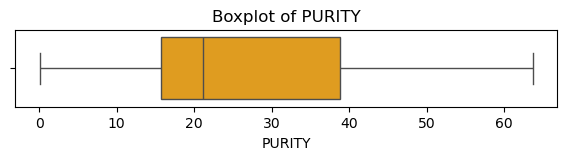

In [36]:
plt.figure(figsize=(7, 1))
sns.boxplot(x=purity, color='orange')
plt.title('Boxplot of PURITY')
plt.show()

Observation : There doesn't seem to be any outlier in the purities. Let's look its distribution more in details: 

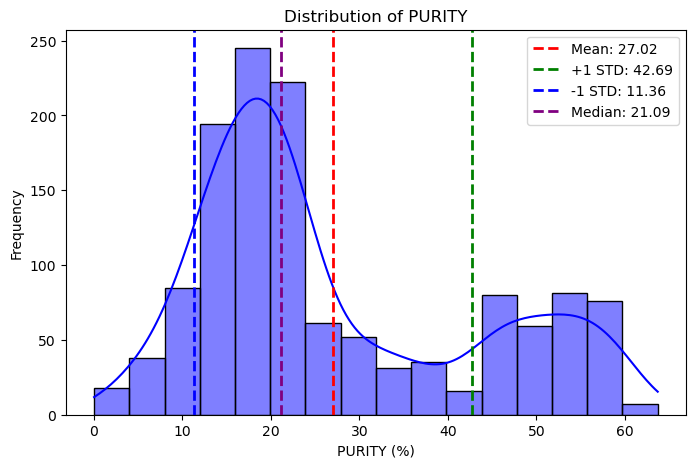

In [37]:
# Histogram for PURITY
mean_purity = np.mean(purity)
median_purity = np.median(purity)
std_purity = np.std(purity)

plt.figure(figsize=(8, 5))
sns.histplot(purity, kde=True, color='blue')
plt.axvline(mean_purity, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_purity:.2f}')
plt.axvline(mean_purity + std_purity, color='green', linestyle='dashed', linewidth=2, label=f'+1 STD: {mean_purity + std_purity:.2f}')
plt.axvline(mean_purity - std_purity, color='blue', linestyle='dashed', linewidth=2, label=f'-1 STD: {mean_purity - std_purity:.2f}')
plt.axvline(median_purity, color='purple', linestyle='dashed', linewidth=2, label=f'Median: {median_purity:.2f}')
plt.legend()
plt.xlabel('PURITY (%)')
plt.ylabel('Frequency')
plt.title('Distribution of PURITY')
plt.show()

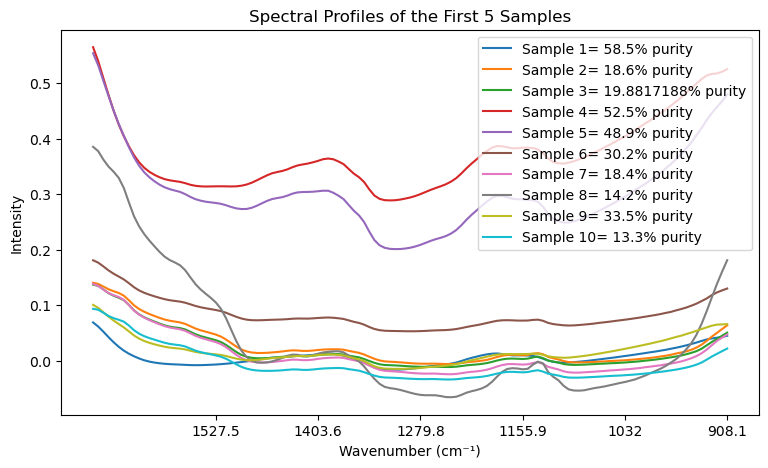

In [38]:
# Plot the spectral profiles for the first 10 samples
plt.figure(figsize=(9, 5))

for i in range(10):
    plt.plot(wavenumbers, spectral_data.iloc[i], label=f'Sample {i+1}= {purity[i]}% purity')

plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('Spectral Profiles of the First 5 Samples')
plt.legend()
plt.xticks(np.linspace(0, 100, 6))
plt.gca().invert_xaxis()  # Invert x-axis for typical IR spectra representation
plt.show()


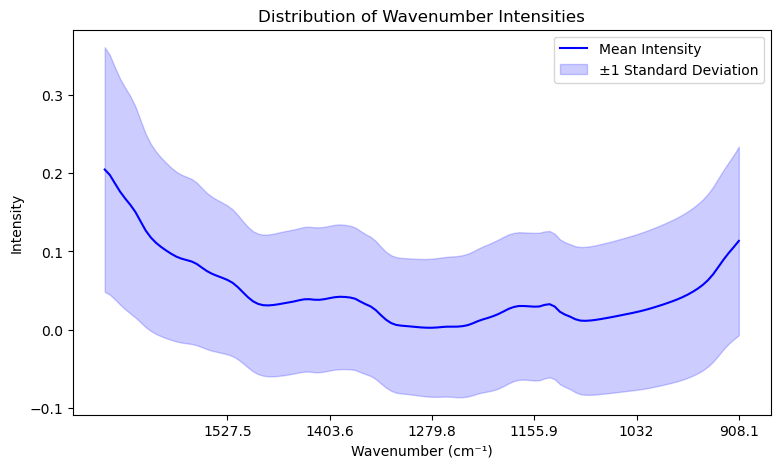

In [39]:
# Vizualization of spectral data
mean_intensity = spectral_data.mean() 
std_intensity = spectral_data.std()  

plt.figure(figsize=(9, 5))
plt.plot(wavenumbers, mean_intensity, label='Mean Intensity', color='blue')

plt.fill_between(
    wavenumbers, 
    mean_intensity - std_intensity, 
    mean_intensity + std_intensity, 
    color='blue', 
    alpha=0.2, 
    label='±1 Standard Deviation'
)

plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('Distribution of Wavenumber Intensities')
plt.legend()
plt.xticks(np.linspace(0, 100, 6))
plt.gca().invert_xaxis()  # Invert x-axis for typical IR spectra representation
plt.show()

In [40]:
# Extract wavelengths that correlate with the target variable (PURITY)
correlation_matrix = raw_train.iloc[:, 5:].corr()
purity_correlations = correlation_matrix['PURITY']
sorted_purity_correlations = purity_correlations.abs().sort_values(ascending=False)
print(sorted_purity_correlations.head(10))

PURITY    1.000000
1639      0.322647
1632.8    0.322144
1626.6    0.314899
1620.5    0.312043
1614.3    0.310319
1608.1    0.307110
1645.2    0.306612
1601.9    0.301968
1595.7    0.294692
Name: PURITY, dtype: float64


In [41]:
raw_train.replace(r'^\s*$', np.nan, regex=True, inplace=True)
print('Number of missing values', raw_train.isnull().sum().sum())

Number of missing values 0


In [42]:
raw_train['substance_form_display'].unique()

array(['Homogenized Powder', 'Non homogenized powder', 'Unspecified'],
      dtype=object)

In [43]:
# group by substance_form_display and calculate plot the mean and median purity
grouped = raw_train.groupby('substance_form_display')['PURITY'].agg(['mean', 'median'])
print(grouped)

                             mean     median
substance_form_display                      
Homogenized Powder      28.167888  22.478586
Non homogenized powder  21.703576  20.548364
Unspecified             27.935076  20.400000


Observation: The means and medians of the different substance forms do not show a big difference with the mean and median of the total samples. (Respectively 27.02 and 21.09). The form of the samples may not be relevant for predicting the purity.

### Exploratory Data analysis of substances.csv

In [44]:
raw_substances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Columns: 126 entries, substance to 1676.2
dtypes: float64(125), object(1)
memory usage: 1.4+ MB


Most common substances: Index(['cocaine', 'MDMA', '2C-B', 'FA', 'ketamine'], dtype='object', name='substance')


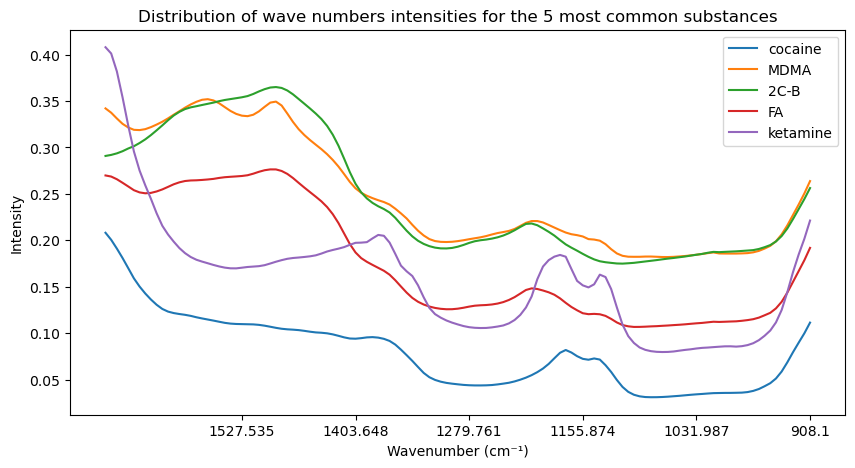

In [45]:
# group by substance and calculate the mean purity
substances = raw_substances.groupby('substance').mean()

# what are the most common substances?
substances_count = raw_substances['substance'].value_counts()
most_common_substances = substances_count.head(5).index
print('Most common substances:', most_common_substances)

# Plot the mean purity of most common substances
plt.figure(figsize=(10, 5))
for substance in most_common_substances:
    plt.plot(substances.columns, substances.loc[substance].values, label=substance)
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.xticks(np.linspace(0, 100, 6))
plt.title('Distribution of wave numbers intensities for the 5 most common substances')
plt.gca().invert_xaxis()  # Invert x-axis for typical IR spectra representation
plt.legend()
plt.show()


# 2. Preprocessing
In this section you have code for preprocessing, cleaning and feature engineering.

In [46]:
def preprocess_spectral_data(data):
    spectrum = data.iloc[:, 6:]  # Extract spectral columns
    # Apply Savitzky-Golay filter 
    spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv=2, axis=1))
    # Standardize the filtered data (z-score normalization)
    spectrum_filtered_standardized = pd.DataFrame(zscore(spectrum_filtered, axis=1))
    return spectrum_filtered_standardized

# Define a custom reliability scoring function for ±5% tolerance
def reliability_score(y_true, y_pred, tolerance=5):
    within_tolerance = np.abs(y_true - y_pred) <= tolerance
    return np.mean(within_tolerance)


# 3. Linear Model


### 3.1. Preprocessing and stuff

In [49]:
data = pd.read_csv("data/train.csv")

# Extract spectrum data (columns from index 6 onward)
spectrum = data.iloc[:, 6:]

# Apply Savitzky-Golay filter for preprocessing
spectrum_filtered_array = savgol_filter(spectrum, 7, 3, deriv=2, axis=1)

# Ensure the shape matches the original spectrum
spectrum_filtered = pd.DataFrame(spectrum_filtered_array, columns=spectrum.columns[:spectrum_filtered_array.shape[1]])

# Standardize the filtered spectrum
spectrum_standardized = pd.DataFrame(zscore(spectrum_filtered, axis=1), columns=spectrum_filtered.columns)

# Feature selection: Remove low-variance features
var_thresh = VarianceThreshold(threshold=0.01)
spectrum_selected = var_thresh.fit_transform(spectrum_standardized)
spectrum_selected = pd.DataFrame(spectrum_selected)

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
spectrum_poly = poly.fit_transform(spectrum_selected)
spectrum_poly = pd.DataFrame(spectrum_poly)

# Define the target variable
y = data['PURITY']

# Define a custom reliability scoring function for ±5% tolerance

reliability_scorer = make_scorer(reliability_score, greater_is_better=True)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(spectrum_poly, y, test_size=0.2, random_state=42)


### 3.2. Model

In [50]:
# Define the model pipeline with Ridge Regression
ridge = Ridge()
param_grid = {'alpha': np.logspace(-3, 3, 20)}

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('ridge', Ridge())
])

# Perform grid search with cross-validation to find the best alpha
grid_search = GridSearchCV(pipeline, {'ridge__alpha': param_grid['alpha']}, cv=5, scoring=reliability_scorer)
grid_search.fit(X_train, y_train)

# Display best parameters and best score
print("Best alpha found:", grid_search.best_params_['ridge__alpha'])
print("Best cross-validation reliability score:", grid_search.best_score_)

# Test the model on the test set
final_model = grid_search.best_estimator_
y_test_pred = final_model.predict(X_test)

# Calculate reliability score on the test set for ±5% tolerance
test_score_5 = reliability_score(y_test, y_test_pred)

print("Test Reliability Score (Fraction within ±5% tolerance):", test_score_5)

KeyboardInterrupt: 

### 3.3. Submission

In [50]:
#TO BE USED IF YOU WANT TO MAKE A CSV FILE WITH THE PREDICTIONS FROM THIS MODEL

# Load and preprocess the test dataset for predictions
test_data = pd.read_csv("data/test.csv")
test_spectrum = test_data.iloc[:, 5:]
test_spectrum_filtered_array = savgol_filter(test_spectrum, 7, 3, deriv=2, axis=1)

# Ensure the shape matches the original spectrum
test_spectrum_filtered = pd.DataFrame(test_spectrum_filtered_array, columns=spectrum.columns[:test_spectrum_filtered_array.shape[1]])

# Standardize and transform the test spectrum
test_spectrum_standardized = pd.DataFrame(zscore(test_spectrum_filtered, axis=1))
test_spectrum_selected = var_thresh.transform(test_spectrum_standardized)
test_spectrum_poly = poly.transform(test_spectrum_selected)

# Make predictions using the trained model
test_predictions = final_model.predict(test_spectrum_poly)

# Create an output DataFrame in the required format
output = pd.DataFrame({
    "ID": test_data.index + 1,  # Assuming IDs are sequential starting from 1
    "PURITY": test_predictions
})

# Save predictions to a CSV file
output.to_csv("predictions_linear.csv", index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


> ### First results
A small alpha (like 0.1) indicates that only a slight amount of regularization is applied.
This suggests the model does not need heavy penalization of large coefficients, implying that the features are meaningful and the data is not excessively noisy. The best cross-validation reliability score is the average reliability score (fraction of predictions within ±5% of true PURITY) across 5-fold cross-validation on the training data. The model correctly predicts within ±5% tolerance for approximately 85.8% of samples in the cross-validation splits. This score reflects the model's ability to generalize to unseen data (from training folds).

The model achieves a reliability score of approximately 87.3% on the test set. This means that 87.3% of predictions on the test set are within ±5% of the true PURITY value. The test score being slightly higher than the cross-validation score suggests the model is robust and performs consistently across datasets.

# 4. Non-Linear Models

### 4.1 Random Forest

In this model, we tried taking information from the "substances.csv" file. For this, we trained another model to extract blablabla je vais remplir ça après

Results : ça change r

Here is the model for substance file analysis :

In [51]:
file_path = 'data/substances.csv'
data = pd.read_csv(file_path)

target_column = 'substance'
X = data.drop(columns=[target_column])
y = data[target_column]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the features (optional but recommended for XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the XGBoost classifier
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

unique_labels = sorted(set(y_test))
#print(classification_report(y_test, y_pred, target_names=label_encoder.classes_[unique_labels], labels=unique_labels))


# Save the model
model.save_model('models/xgboost_classifier_model.json')
print("Model saved to models/xgboost_classifier_model.json")

Accuracy: 0.7422
Model saved to models/xgboost_classifier_model.json


To enable this substance file analysis, turn this boolean to true

In [52]:
add_substance_classif = False #Switch to true to enable substance analysis

#### 4.1.1 Preprocessing

In [53]:
def pre_process_data(file_path: str, add_substance_classif = add_substance_classif):
    """
    Preprocess the dataset:
    - Drop 'sample_name' and 'prod_substance' columns.
    - Convert string keys in 'device_serial', 'substance_form_display', and 'measure_type_display' to numeric values.
    - (Optionnal) Add substance classification into account in the model 

    Args:
        file_path (str): Path to the CSV file.
        add_substance_classif (bool): Add the substance classification feature 
    Returns:
        pd.DataFrame: Preprocessed dataset.
    """

    df = pd.read_csv(file_path)

    # Drop columns
    columns_to_drop = ['sample_name', 'prod_substance']
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Label encoder
    string_columns = ['device_serial', 'substance_form_display', 'measure_type_display']
    for col in string_columns:
        if col in df.columns:
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col])

    # Tranform spectrum

    spectrum = df.iloc[:, 4:]
    spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 1), columns=spectrum.columns)
    spectrum_filtered_standardized = pd.DataFrame(zscore(spectrum_filtered, axis = 1), columns=spectrum.columns)
    df = pd.concat([df.iloc[:, :4], spectrum_filtered_standardized], axis=1)

    # Add substance classification

    if add_substance_classif:
        substance_model = XGBClassifier()
        substance_model.load_model('models/xgboost_classifier_model.json')
        spectrum_data = df.iloc[:, 4:] 
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(spectrum_data)
        predictions = substance_model.predict(scaled_data)
        df['substance_class'] = predictions

    return df

#### 4.1.2 Model

- Bayesian Hyperparameter Search

In [54]:
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 400)
    max_depth = trial.suggest_int("max_depth", 10, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)

    # Define and train Random Forest model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Cross-validate and return custom purity score
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring=custom_scorer).mean()
    return cv_score

data = pre_process_data("data/train.csv")
X = data.drop(columns=['PURITY'])
y = data['PURITY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

custom_scorer = make_scorer(purity_score, greater_is_better=True)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("Best Parameters:", best_params)

best_rf_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)
best_rf_model.fit(X_train, y_train)

# Evaluate the model on test data
y_pred = best_rf_model.predict(X_test)
final_score = purity_score(y_test, y_pred)
print(f"Final Optimized Random Forest Custom Purity Score (within ±5% range): {final_score:.4f}")


[I 2024-12-20 15:02:35,179] A new study created in memory with name: no-name-de76f35e-b7ec-4b10-bfb5-f1fbc0592020
[I 2024-12-20 15:05:46,541] Trial 0 finished with value: 0.951923076923077 and parameters: {'n_estimators': 395, 'max_depth': 23, 'min_samples_split': 9}. Best is trial 0 with value: 0.951923076923077.
[I 2024-12-20 15:09:31,284] Trial 1 finished with value: 0.9548076923076924 and parameters: {'n_estimators': 350, 'max_depth': 28, 'min_samples_split': 5}. Best is trial 1 with value: 0.9548076923076924.
[I 2024-12-20 15:11:22,144] Trial 2 finished with value: 0.9509615384615385 and parameters: {'n_estimators': 218, 'max_depth': 21, 'min_samples_split': 7}. Best is trial 1 with value: 0.9548076923076924.
[W 2024-12-20 15:13:31,913] Trial 3 failed with parameters: {'n_estimators': 383, 'max_depth': 16, 'min_samples_split': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\lauri\anaconda3\envs\MLCourse\lib\site-packages\

KeyboardInterrupt: 

You can then input the values found for the hyperparameters in the model below

In [45]:
data = pre_process_data("data/train.csv") 

X = data.drop(columns=['PURITY'])
y = data['PURITY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

#input the values here !
best_rf_model = RandomForestRegressor(
    n_estimators=317,
    max_depth=16,
    min_samples_split=9,
    random_state=42
)
best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)

joblib.dump(best_rf_model, "models/random_forest_model.joblib") #saves the model
final_score = reliability_score(y_test, y_pred)
print(f"Final Optimized Random Forest Custom Purity Score (within ±5% range): {final_score:.4f}")

KeyboardInterrupt: 

### Create the submission file

In [55]:
best_rf_model = joblib.load("models/random_forest_model.joblib")

test_data = pd.read_csv("data/test.csv")
X_test_data = pre_process_data("data/test.csv", add_substance_classif)

predicted_purity = best_rf_model.predict(X_test_data)

submission = pd.DataFrame({
    "ID": test_data.index + 1, 
    "PURITY": predicted_purity
})

submission.to_csv("predictions_random_forest.csv", index=False)
print("Predictions saved to predictions_random_forest.csv")

Predictions saved to predictions_random_forest.csv


C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### 4.2 Neural Network

This model also has a different substance file analysis.

In [56]:
class IRClassificationCNN(nn.Module):
    def __init__(self, num_classes):
        super(IRClassificationCNN, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )
        
        cnn_output_size = 960  # Calculate the flattened output size of the CNN
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.cnn(x)
        x = self.fc(x)
        return x
    

# TRAINING

# Set random seeds for reproducibility
seed = 42  # Choose any fixed number for the seed
np.random.seed(seed)  # For NumPy
torch.manual_seed(seed)  # For PyTorch CPU
torch.cuda.manual_seed(seed)  # For PyTorch GPU
torch.cuda.manual_seed_all(seed)  # For all GPUs if using multiple
torch.backends.cudnn.deterministic = True  # Ensure deterministic operations in CUDA
torch.backends.cudnn.benchmark = False  # Avoid non-deterministic algorithms in CUDA

def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)  # You can use the same seed or modify it slightly for each worker

# Load the dataset
file_path = './data/substances.csv'
data = pd.read_csv(file_path)

# Preprocess the data
# Separate features and target
target = data.iloc[:, 0]  # First column is the target (substance name)
ir_data = data.iloc[:, 1:]  # Remaining columns are IR data

# Encode the target labels
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Standardize the IR data
scaler = StandardScaler()
ir_data_scaled = scaler.fit_transform(ir_data)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    ir_data_scaled, target_encoded, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, worker_init_fn=worker_init_fn)

# Initialize the model
num_classes = len(label_encoder.classes_)
model = IRClassificationCNN(num_classes=num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), 'ir_classification_cnn.pth')
print("Model saved to 'ir_classification_cnn.pth'")




Epoch [1/200], Loss: 2.9960
Epoch [2/200], Loss: 2.4217
Epoch [3/200], Loss: 2.2011
Epoch [4/200], Loss: 1.9341
Epoch [5/200], Loss: 1.7178
Epoch [6/200], Loss: 1.4853
Epoch [7/200], Loss: 1.3247
Epoch [8/200], Loss: 1.1303
Epoch [9/200], Loss: 1.0096
Epoch [10/200], Loss: 0.8607
Epoch [11/200], Loss: 0.8284
Epoch [12/200], Loss: 0.6896
Epoch [13/200], Loss: 0.6167
Epoch [14/200], Loss: 0.6070
Epoch [15/200], Loss: 0.5431
Epoch [16/200], Loss: 0.4557
Epoch [17/200], Loss: 0.4521
Epoch [18/200], Loss: 0.4313
Epoch [19/200], Loss: 0.3748
Epoch [20/200], Loss: 0.3609
Epoch [21/200], Loss: 0.3474
Epoch [22/200], Loss: 0.3261
Epoch [23/200], Loss: 0.2953
Epoch [24/200], Loss: 0.3451
Epoch [25/200], Loss: 0.3126
Epoch [26/200], Loss: 0.2617
Epoch [27/200], Loss: 0.2123
Epoch [28/200], Loss: 0.2448
Epoch [29/200], Loss: 0.2349
Epoch [30/200], Loss: 0.2028
Epoch [31/200], Loss: 0.1973
Epoch [32/200], Loss: 0.2397
Epoch [33/200], Loss: 0.2057
Epoch [34/200], Loss: 0.1998
Epoch [35/200], Loss: 0

And then one can run it on the test dataset

In [58]:
model = IRClassificationCNN(87)
model.load_state_dict(torch.load('ir_classification_cnn.pth'))

model.eval()

data = pd.read_csv('./data/test.csv')
data = data.iloc[:, -125:]

scaler = StandardScaler()
ir_data_scaled = scaler.fit_transform(data.astype(np.float32))
ir_data_scaled = torch.tensor(ir_data_scaled)


with torch.no_grad():
    predictions = model(ir_data_scaled)
    result = pd.DataFrame(predictions)

result.to_csv('./data/test_predictions_substances.csv')

C:\Users\Matteo\AppData\Local\Temp\ipykernel_14372\187715198.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ir_classification_cnn.pth'

#### 4.2.1 Preprocessing  

In [67]:
def pre_process_data(file_path: str, transform_spectrum: bool, add_substance_classif: bool, save_encoders: bool, encoders: None | object = None):
    """
    Preprocess the dataset:
    - Drop 'sample_name' and 'prod_substance' columns.
    - Convert string keys in 'device_serial', 'substance_form_display', and 'measure_type_display' to numeric values.
    - (Optionnal) transforms the spectrum using savgol filter and zscore 

    Args:
        file_path (str): Path to the CSV file.
        transform_spectrum (bool): Indicates whether or not the spectrum should be transformed using procedure given in the subject
        add_substance_classif (bool): Add the substance classification feature 
    Returns:
        pd.DataFrame: Preprocessed dataset.
    """

    df = pd.read_csv(file_path)

    # Drop columns
    columns_to_drop = ['sample_name', 'prod_substance']
    df = df.drop(columns=columns_to_drop, errors='ignore')
    
    # Label encoder
    if(encoders == None):    
        encoders = {
            'device_serial': LabelEncoder(),
            'substance_form_display': LabelEncoder(),
            'measure_type_display': LabelEncoder()
        }

        encoders['device_serial'].fit(df['device_serial'])
        encoders['substance_form_display'].fit(df['substance_form_display'])
        encoders['measure_type_display'].fit(df['measure_type_display'])

    df['device_serial'] = safe_transform(df['device_serial'], encoders['device_serial'])
    df['substance_form_display'] = safe_transform(df['substance_form_display'], encoders['substance_form_display'])
    df['measure_type_display'] = safe_transform(df['measure_type_display'], encoders['measure_type_display'])

    # Save the encoders to a file
    if(save_encoders):
        with open('encoders.pkl', 'wb') as f:
            pickle.dump(encoders, f)

    print("Encoders saved to encoders.pkl")

    # Tranform spectrum
    if transform_spectrum:
        spectrum = df.iloc[:, 4:]
        spectrum_filtered_standardized = savgol(spectrum)
        df = pd.concat([df.iloc[:, :4], spectrum_filtered_standardized], axis=1)

    if add_substance_classif:

        df_substances = pd.read_csv('./data/substances.csv')
        num_substance_classes = df_substances.iloc[:, 0].nunique()

        substance_model = IRClassificationCNN(num_substance_classes)
        substance_model.load_state_dict(torch.load("ir_classification_cnn.pth"))
        substance_model.eval()

        scaler = StandardScaler()
        ir_data_scaled = scaler.fit_transform(df.iloc[:, 4:].astype(np.float32))
        ir_data_scaled = torch.tensor(ir_data_scaled)

        with torch.no_grad():
            predictions = pd.read_csv("./data/predictions_substances.csv")
            #predictions = pd.read_csv("../data/test_predictions_substances.csv")
            predictions = predictions.drop(columns=['index'])
            df = pd.concat([df, predictions], axis=1)

    return df

def safe_transform(column, encoder, default_value=0):
    """Safely transform a column using a LabelEncoder, mapping unseen values to a default."""
    known_classes = set(encoder.classes_)  # Get the known classes from the encoder
    column_mapped = column.apply(lambda x: x if x in known_classes else encoder.classes_[0])  # Map unseen labels
    return encoder.transform(column_mapped)

def savgol(spectrum):
    spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0), columns=spectrum.columns)
    spectrum_filtered_standardized = pd.DataFrame(zscore(spectrum_filtered, axis = 1), columns=spectrum.columns)
    return spectrum_filtered_standardized

#### 4.2.2 Model

In [68]:

class FCCNNModel(nn.Module):
    def __init__(self, num_devices, num_substance_forms, num_measure_types):
        super(FCCNNModel, self).__init__()
        
        # Spectrum Module
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
        )
        
        # Metadata Embedding
        self.device_embedding = nn.Embedding(num_devices, 8)
        self.substance_form_embedding = nn.Embedding(num_substance_forms, 1)
        self.measure_type_embedding = nn.Embedding(num_measure_types, 1)
        self.ir_dim_reduc = nn.Sequential(
            nn.Linear(87, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Metadata Fully Connected
        self.metadata_fc = nn.Sequential(
            nn.Linear(8 + 1 + 1 + 256, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Metadata Projection to Match Spectrum Features
        self.metadata_projection = nn.Linear(128, 256)

        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(1504, 128),  # Adjust for concatenated input
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, inputs):
        spectrum, device_serial, substance_form, measure_type, ir_predictions = inputs
        
        # Spectrum through CNN
        spectrum = spectrum.unsqueeze(1)  # Add channel dimension
        spectrum_features = self.cnn(spectrum)  # Output size: (B, 992)
        
        # Metadata through embeddings
        device_embed = self.device_embedding(device_serial)
        substance_form_embed = self.substance_form_embedding(substance_form)
        measure_type_embed = self.measure_type_embedding(measure_type)
        ir_reduced = self.ir_dim_reduc(ir_predictions)

        # Combine metadata embeddings
        metadata = torch.cat([device_embed, substance_form_embed, measure_type_embed, ir_reduced], dim=1)
        metadata_features = self.metadata_fc(metadata)  # Output size: (B, 16)
        #metadata_features = self.metadata_projection(metadata_features)  # Output size: (B, 960)
        
        # Concatenate features
        combined_features = torch.cat([spectrum_features, metadata_features], dim=1)  # Output size: (B, 1920)
        output = self.fc(combined_features)
        return output

Train the model

In [69]:
seed = 42  # Choose any fixed number for the seed

torch.manual_seed(seed)  # For PyTorch CPU
torch.cuda.manual_seed(seed)  # For PyTorch GPU
torch.cuda.manual_seed_all(seed)  # For all GPUs if using multiple
torch.backends.cudnn.deterministic = True  # Ensure deterministic operations in CUDA
torch.backends.cudnn.benchmark = False  # Avoid non-deterministic algorithms in CUDA

# Define worker_init_fn to ensure reproducibility with DataLoader
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)  # You can use the same seed or modify it slightly for each worker

# Load and Preprocess Data
file_path = './data/train.csv'  # Adjust path if necessary
data = pre_process_data(file_path, False, True, True)
metadata = pd.concat([data.iloc[:, :3], data.iloc[:, -87:]], axis=1) # Assuming first three columns are metadata and last is predicted substance
spectrum = data.iloc[:, 4:].iloc[:, :-87] # All columns except target
target = data.iloc[:, 3]/100 # Get purity percentage as float
#print(metadata, target)

# Split data into train and test sets
meta_train, meta_test, spec_train, spec_test, y_train, y_test = train_test_split(
    metadata, spectrum, target, test_size=0.2, random_state=42
)

# Split training set into training and validation
meta_train, meta_val, spec_train, spec_val, y_train, y_val = train_test_split(
    meta_train, spec_train, y_train, test_size=0.2, random_state=42
)

#print(meta_train, meta_val, meta_test)

# Convert training data to PyTorch tensors
device_serial_tensor = torch.tensor(meta_train.iloc[:, 0].values, dtype=torch.long)
substance_form_tensor = torch.tensor(meta_train.iloc[:, 1].values, dtype=torch.long)
measure_type_tensor = torch.tensor(meta_train.iloc[:, 2].values, dtype=torch.long)
predicted_substance_tensor = torch.tensor(meta_train.iloc[:, -87:].values, dtype=torch.float32)
spec_train_tensor = torch.tensor(spec_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Convert validation data to PyTorch tensors
device_serial_val_tensor = torch.tensor(meta_val.iloc[:, 0].values, dtype=torch.long)
substance_form_val_tensor = torch.tensor(meta_val.iloc[:, 1].values, dtype=torch.long)
measure_type_val_tensor = torch.tensor(meta_val.iloc[:, 2].values, dtype=torch.long)
predicted_substance_val_tensor = torch.tensor(meta_val.iloc[:, -87:].values, dtype=torch.float32)
spec_val_tensor = torch.tensor(spec_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Convert test data to PyTorch tensors
device_serial_test_tensor = torch.tensor(meta_test.iloc[:, 0].values, dtype=torch.long)
substance_form_test_tensor = torch.tensor(meta_test.iloc[:, 1].values, dtype=torch.long)
measure_type_test_tensor = torch.tensor(meta_test.iloc[:, 2].values, dtype=torch.long)
predicted_substance_test_tensor = torch.tensor(meta_test.iloc[:, -87:].values, dtype=torch.float32)
spec_test_tensor = torch.tensor(spec_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoaders for batching
train_dataset = TensorDataset(device_serial_tensor, substance_form_tensor, measure_type_tensor, predicted_substance_tensor, spec_train_tensor, y_train_tensor)
val_dataset = TensorDataset(device_serial_val_tensor, substance_form_val_tensor, measure_type_val_tensor, predicted_substance_val_tensor, spec_val_tensor, y_val_tensor)
test_dataset = TensorDataset(device_serial_test_tensor, substance_form_test_tensor, measure_type_test_tensor, predicted_substance_test_tensor, spec_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, worker_init_fn=worker_init_fn)

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pth'):
        """
        Args:
            patience (int): How many epochs to wait after the last time validation loss improved.
            delta (float): Minimum change in validation loss to qualify as an improvement.
            path (str): Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)  # Save the best model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize Model
num_devices = metadata.iloc[:, 0].nunique()
num_substance_forms = metadata.iloc[:, 1].nunique()
num_measure_types = metadata.iloc[:, 2].nunique()
spectrum_input_size = spec_train.shape[1]

model = FCCNNModel(num_devices, num_substance_forms, num_measure_types)

# Define Loss and Optimizer
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Train Model
early_stopping = EarlyStopping(patience=50, delta=0, path='best_model.pth')

num_epochs = 1000
for epoch in range(num_epochs):
    
    # Training Phase
    train_correct_guesses = 0
    train_total_samples = 0
    correct_guesses = 0
    total_samples = 0

    model.train()
    train_loss = 0
    for batch_device, batch_form, batch_type, batch_ir_predictions, batch_spec, batch_y in train_loader:

        outputs = model((batch_spec, batch_device, batch_form, batch_type, batch_ir_predictions))
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        train_lower_bound = batch_y - 0.05
        train_upper_bound = batch_y + 0.05
        train_correct = ((outputs >= train_lower_bound) & (outputs <= train_upper_bound)).sum().item()
        train_correct_guesses += train_correct
        train_total_samples += batch_y.size(0)
    
    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_device, batch_form, batch_type, batch_ir_predictions, batch_spec, batch_y in val_loader:
            outputs = model((batch_spec, batch_device, batch_form, batch_type, batch_ir_predictions))
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            
            lower_bound = batch_y - 0.05
            upper_bound = batch_y + 0.05
            correct = ((outputs >= lower_bound) & (outputs <= upper_bound)).sum().item()
            correct_guesses += correct
            total_samples += batch_y.size(0)

    # Average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_accuracy = (train_correct_guesses / train_total_samples) * 100
    val_accuracy = (correct_guesses / total_samples) * 100

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy : {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")
    
    # Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate Model
model.eval()
test_loss = 0
correct_guesses = 0
total_samples = 0
y_pred = []
y_true = []
with torch.no_grad():
    for batch_device, batch_form, batch_type, batch_ir_predictions, batch_spec, batch_y in test_loader:
        outputs = model((batch_spec, batch_device, batch_form, batch_type, batch_ir_predictions))
        y_pred.extend(outputs.view(-1).cpu().numpy())
        y_true.extend(batch_y.view(-1).cpu().numpy())

        # Calculate correct guesses within ±5%
        lower_bound = batch_y - 0.05
        upper_bound = batch_y + 0.05

        correct = ((outputs >= lower_bound) & (outputs <= upper_bound)).sum().item()
        
        correct_guesses += correct
        total_samples += batch_y.size(0)

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)
print(f"Test MSE: {mse:.4f}")

accuracy = (correct_guesses / total_samples) * 100
print(f"Accuracy (% within ±5%): {accuracy:.2f}%")

Encoders saved to encoders.pkl


C:\Users\Matteo\AppData\Local\Temp\ipykernel_14372\1730986803.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  substance_model.load_state_dict(torch.load("ir_classificat

Epoch [1/1000], Train Loss: 0.0330, Val Loss: 0.0088, Train Accuracy : 18.99%, Val Accuracy: 47.12%
Epoch [2/1000], Train Loss: 0.0065, Val Loss: 0.0060, Train Accuracy : 39.54%, Val Accuracy: 44.71%
Epoch [3/1000], Train Loss: 0.0035, Val Loss: 0.0034, Train Accuracy : 53.49%, Val Accuracy: 50.48%
Epoch [4/1000], Train Loss: 0.0030, Val Loss: 0.0025, Train Accuracy : 54.33%, Val Accuracy: 56.25%
Epoch [5/1000], Train Loss: 0.0027, Val Loss: 0.0034, Train Accuracy : 55.29%, Val Accuracy: 37.98%
Epoch [6/1000], Train Loss: 0.0024, Val Loss: 0.0037, Train Accuracy : 60.46%, Val Accuracy: 42.31%
Epoch [7/1000], Train Loss: 0.0028, Val Loss: 0.0016, Train Accuracy : 53.12%, Val Accuracy: 63.94%
Epoch [8/1000], Train Loss: 0.0029, Val Loss: 0.0046, Train Accuracy : 56.13%, Val Accuracy: 37.02%
Epoch [9/1000], Train Loss: 0.0023, Val Loss: 0.0015, Train Accuracy : 57.45%, Val Accuracy: 69.71%
Epoch [10/1000], Train Loss: 0.0025, Val Loss: 0.0026, Train Accuracy : 55.41%, Val Accuracy: 52.88%

C:\Users\Matteo\AppData\Local\Temp\ipykernel_14372\1044045353.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Submission

In [72]:

# Load the model structure
model = FCCNNModel(
    48,  # 48 device serial classes
    3,  # 3 substance form classes
    2  # 2 measure type classes
)

with open('encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

print("Encoders loaded from encoders.pkl")

# Load the saved weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode

# Load and preprocess test data
file_path = './data/test.csv'  # Adjust path if necessary
data = pre_process_data(file_path, False, True, False, encoders)

# Split metadata and spectrum
metadata = pd.concat([data.iloc[:, :3], data.iloc[:, -87:]], axis=1) # Assuming first three columns are metadata and last is predicted substance
spectrum = data.iloc[:, 3:].iloc[:, :-87] # All columns except target


# Convert data to tensors
device_serial_test_tensor = torch.tensor(metadata['device_serial'].values, dtype=torch.long)
substance_form_test_tensor = torch.tensor(metadata['substance_form_display'].values, dtype=torch.long)
measure_type_test_tensor = torch.tensor(metadata['measure_type_display'].values, dtype=torch.long)
predicted_substance_test_tensor = torch.tensor(metadata.iloc[:, -87:].values, dtype=torch.float32)
spec_test_tensor = torch.tensor(spectrum.values, dtype=torch.float32)

# Print debug information

print(f"Max index in test measure_type: {metadata['measure_type_display'].max()}")
print(f"Embedding size for measure_type: {model.measure_type_embedding.num_embeddings}")
print(f"Max index in test device_serial: {metadata['device_serial'].max()}")
print(f"Embedding size for device_serial: {model.device_embedding.num_embeddings}")
print(f"Max index in test substance_form_display: {metadata['substance_form_display'].max()}")
print(f"Embedding size for substance_form_display: {model.substance_form_embedding.num_embeddings}")

max_train_index_device = model.device_embedding.num_embeddings - 1
max_train_index_form = model.substance_form_embedding.num_embeddings - 1
max_train_index_measure = model.measure_type_embedding.num_embeddings - 1

# Assign unseen classes to default value
metadata['device_serial'] = metadata['device_serial'].apply(
    lambda x: x if x <= max_train_index_device else 0
)
metadata['substance_form_display'] = metadata['substance_form_display'].apply(
    lambda x: x if x <= max_train_index_form else 0
)
metadata['measure_type_display'] = metadata['measure_type_display'].apply(
    lambda x: x if x <= max_train_index_measure else 0
)

# Run the entire test data through the model
with torch.no_grad():
    predictions = model((spec_test_tensor, device_serial_test_tensor, substance_form_test_tensor, measure_type_test_tensor, predicted_substance_test_tensor))
    predictions = predictions.view(-1).cpu().numpy()  # Convert to a NumPy array

# Load the sample submission file (if provided by the competition)
submission = pd.DataFrame({'ID': data.index+1, 'PURITY': predictions*100})  # Adjust 'Id' to match your test file

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")

Encoders loaded from encoders.pkl
Encoders saved to encoders.pkl
Max index in test measure_type: 1.0
Embedding size for measure_type: 2
Max index in test device_serial: 47.0
Embedding size for device_serial: 48
Max index in test substance_form_display: 2.0
Embedding size for substance_form_display: 3


C:\Users\Matteo\AppData\Local\Temp\ipykernel_14372\62948915.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
C:\Users

IndexError: index out of range in self

# 5. Summary and Conclusions
This section does not contain any code, but a summary and conclusion of your findings in
the form of figures and text.